### Create a multi-Gaussian catalog and convert to a mesh

In [1]:
import numpy as np 

from LSS_python.mesh import Mesh 

In [2]:
boxsize = 1000.0 
size = int(1e+7)
position = np.random.multivariate_normal(mean=[boxsize/2.0, boxsize/2.0, boxsize/2.0], cov=[[boxsize/4.0, 0.0, 0.0], [0.0, boxsize/4.0, 0.0], [0.0, 0.0, boxsize/4.0]], size=size)
mesh = Mesh(Nmesh=1024, BoxSize=boxsize)
mesh.to_mesh(
    pos=position,
    resampler="CIC", # Support "NGP", "CIC", "TSC", "PCS" 
    interlaced=False, # Support interlaced=True 
    weights=None,
    values=None, # Just the same as nbodykit 
    nthreads=10, # Only be valid when c_api=True 
    c_api=True,
    is_norm=True, # Obtain a delta field
    device_id=-1, # If >=0, use GPU and specify GPU id
    field_extern=None, # If not None, use this field as the output field
) # Not output and the field is stored in mesh.real_field (mesh.real_field_gpu if device_id >= 0)

ValueError: Output array must have the same dtype as positions

In [3]:
type(mesh.real_field)

numpy.ndarray

### Do FFT and calculate power spectrum

In [4]:
from LSS_python.fftpower import FFTPower, deal_ps_3d

In [5]:
mesh.r2c(
    compensated=True, # Support compensation of aliases. Support interlacing.
    device_id=-1, 
    nthreads=10, 
    c_api=True, # The C++ API is for compensation. FFT is done with scipy.
) # No output and the mesh is stored at mesh.complex_field (mesh.complex_field_gpu if GPU is used)

In [6]:
fftpower = FFTPower(Nmesh=1024, BoxSize=boxsize, shotnoise=0.0) # Nmesh must be the same as your field(mesh). The shotnoise will load from mesh object.
power = fftpower.cal_ps_from_mesh(
    mesh, 
    kmin=0.05, 
    kmax=1.0, 
    dk=0.01,
    Nmu=None, # Only be used when mode == "2d" (k-\mu space)
    k_logarithmic=False, # Set True if your need a logarithmic k space,
    ps_3d_inplace=False, # Set True if you want to run faster and do not use the mesh.complex_field again. (It will be modified in place)
    mode="1d",
    nthreads=10, 
    c_api=True, 
    test_mode=False, # A flag for debugging. Do not use it in production.
)

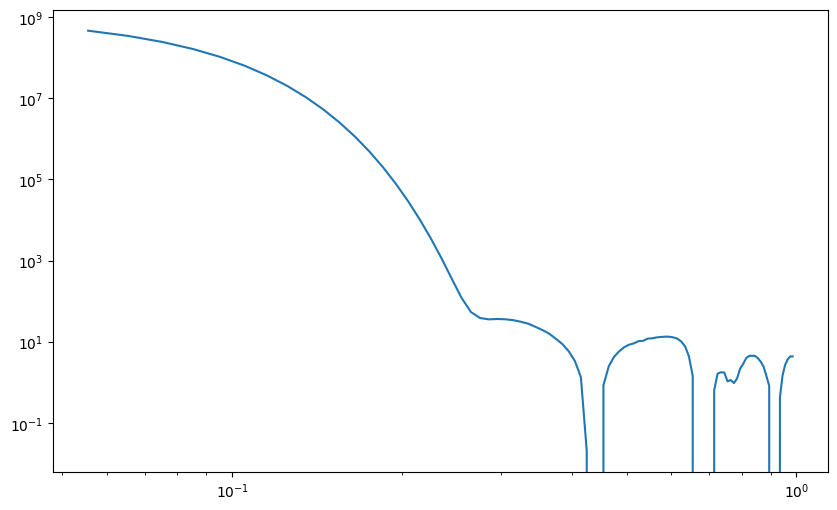

In [7]:
import matplotlib.pyplot as plt 
fig = plt.figure(dpi=100, figsize=(10, 6))
plt.loglog(power["k"], np.real(power["Pk"]))
plt.show()